Compute both finite-N and large-N (Schwinger-Dyson) 2-point functions of SYK Hamiltonian

In [1]:
################# Test parameters ######################

# Actual physical parameters
BETA = 1 # inverse temperature
K = 9 # number of fermionic modes <-- They use K=17 in the paper
J = 4
Q = 4

LAMBDA_BJ = BETA*J
LAMBDA_cutoff = 10

N_ITER = 11 # Number of iterations for which to run the Schwinger-Dyson equation
TAU_TEST = 1/4

# Computational stuff
WEIGHTED_UPDATE = False # Whether to use weighted or unweighted G(omega) update. See Schwinger-Dyson functions below. Use weighted update if not converging (which might be the case for large J)


In [2]:
import os 
import time
import copy
from tqdm import tqdm

import numpy as np 
import matplotlib.pyplot as plt
import scipy
from scipy import sparse, linalg, fft
from scipy.linalg import expm, sinm, cosm
import scipy.integrate as integrate
from scipy.integrate import quad
import pandas as pd

from joblib import Parallel, delayed
from numba import jit, njit, prange

import functools

################## Locals #############################
from hamiltonian_generation import make_H4_sparse


#################### Macros #############################
np.random.seed(0)

# Physical constants
N = 2*K # number of fermions
N_DIM = 2**K # Hilbert space dimensions
#TAU_RANGE = np.arange(-BETA, BETA, 0.1) # imaginary-time domain
TAU_RANGE = np.linspace(-BETA, BETA, 50) # imaginary-time domain

# Computational stuff
N_SAMPLES = 160 # number of samples to generate
N_JOBS = 20 # number of jobs to run in parallel
E_ORDER = 19 # Order to keep of matrix-exponential expansion. Also not given in the paper.

# Directory to save sample Hamiltonians
H_DIR = os.path.join("Simulated Hamiltonians", f"H4_K{K}_J{J}_Q{Q}")
os.makedirs(H_DIR, exist_ok=True)

######## Define Hamiltonian function ###################
H4_func, psi, psi_pairs, psi_quads = make_H4_sparse(K, J, precompute_pairs = True, precompute_quads = True)

####### Define test set ################################
try:
    js_test = np.load(os.path.join("Excel", "Benchmarks", f"js_test_K{K}_J{J}_Q{Q}.npy"))
    H_test = np.load(os.path.join("Excel", "Benchmarks", f"H_test_K{K}_J{J}_Q{Q}.npy"))
    iv_test = np.load(os.path.join("Excel", "Benchmarks", f"iv_test_K{K}_J{J}_Q{Q}.npy"))
except FileNotFoundError: 
    sigma_j = np.sqrt((J**2)*np.math.factorial(Q-1)/(N**(Q-1)))
    j_test = np.random.normal(0, sigma_j, size=tuple([N for i in range(Q)]))
    H_test = H4_func(j_test).toarray()
    iv_test = np.linalg.eigvalsh(H_test)

    np.save(os.path.join("Excel", "Benchmarks", f"js_test_K{K}_J{J}_Q{Q}.npy"), j_test)
    np.save(os.path.join("Excel", "Benchmarks", f"H_test_K{K}_J{J}_Q{Q}.npy"), H_test)
    np.save(os.path.join("Excel", "Benchmarks", f"iv_test_K{K}_J{J}_Q{Q}.npy"), iv_test)

## Define fast matrix-exponential

In [3]:
# Define matrix exponential function
# For K=10, E_ORDER=19 is optimal
# For K=12, E_ORDER=13 is optimal
# See "spectral_form_factor.ipynb"

def matrix_exponential(A, n): # A = matrix, n = order of expansion
    out = np.zeros(A.shape, dtype=np.complex128)
    last_term = np.identity(A.shape[0])
    out += last_term
    for i in range(1, n+1):
        last_term = last_term @ A / i
        out += last_term
    return out

## Define and compute exact, finite-N 2-point function

In [4]:

def G_finite_exact(psi_a, psi_b, H, tau, beta, lam):
    # psi_a, psi_b = fermions
    # tau = imaginary time
    # beta = inverse temperature
    # lam = beta*J
    # Note: a,b,tau,beta,lam are all scalars

    # Note that this if/else basically defines the time-ordering operator
    if tau>0: 
        E_tau = matrix_exponential(-tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential((-beta+tau)*H*lam, E_ORDER)
        num = np.trace(E_beta_tau @ psi_a @ E_tau @ psi_b)
        den = np.trace(E_beta_tau @ E_tau)
        return num/den
    else:
        E_tau = matrix_exponential(tau*H*lam, E_ORDER)
        E_beta_tau = matrix_exponential(-(beta+tau)*H*lam, E_ORDER)
        num = np.trace(E_beta_tau @ psi_b @ E_tau @ psi_a)
        den = np.trace(E_beta_tau @ E_tau)
        return -num/den

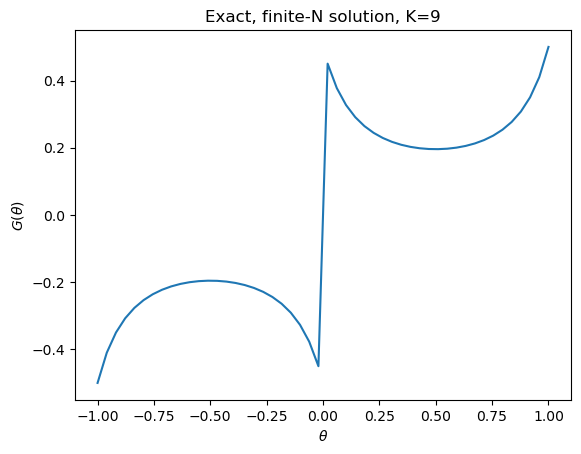

In [5]:
psi_a = psi[0]
psi_b = psi[0]

G_finite_range = Parallel(n_jobs=N_JOBS)(delayed(G_finite_exact)(psi_a, psi_b, H_test, tau, BETA, LAMBDA_BJ) for tau in TAU_RANGE)
G_finite_range = np.real(np.array(G_finite_range))

plt.figure()
plt.plot(TAU_RANGE, G_finite_range)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$G(\theta)$")
plt.title(f"Exact, finite-N solution, K={K}")
plt.show()
plt.close()

## Define Schwinger-Dyson 2-point function (i.e. large-N limit of 2-point function)

$\Sigma_\tau^{(0)}(\tau)=0$

$\Sigma_\tau^{(i)}(\tau) = J^2 [G_{\tau}^{(i-1)} (\tau)]^{q-1}$

$\Sigma^{(i)}(n) = \int_{-\beta/2}^{\beta/2} \Sigma_\tau^{(i)}(\tau)  e^{i\omega_{n}\tau} d\tau$

$G^{(i)}(n) = -\frac{1}{i\omega_{n}+\Sigma^{(i)}(n)}$

$G_\tau^{(i)}(\tau) = \frac{1}{2}sign(\tau) + \frac{1}{\beta} \sum_{n=-\lambda}^\lambda e^{-i \omega_n \tau} [G^{(i)}(n) - G^{(0)}(n)]$

$\omega_n=\frac{2\pi}{\beta}(n+1/2)$

"Guaranteed to converge for small-enough J" 26:00 in video. 

In [6]:
# TODO: Study numerical integration effects, discretization limit and errors, different integration method, parallelization

sigma_tau_memo = {}
def sigma_tau(i, tau):
    if (i, tau) in sigma_tau_memo:
        return sigma_tau_memo[(i, tau)]
    else:
        out = (J**2)*(G_tau(i-1, tau)**(Q-1))
        sigma_tau_memo[(i,tau)] = out
        return out

sigma_memo = {}
def sigma(i,n):
    if (i,n) in sigma_memo:
        return sigma_memo[(i,n)]
    else:
        if i==0:
            sigma_memo[(i,n)] = 0
            return 0
        else:
            #w_n = (2*np.pi/BETA)*(n+1/2)
            #dtau=1e-4
            #sigma_integrand_range = Parallel(n_jobs=N_JOBS)(delayed(sigma_integrand_par_wrapper)(i, tau,w_n) for tau in np.linspace(-BETA/2, BETA/2, int(1/dtau)))
            #integral = dtau*np.sum(sigma_integrand_range)
            # Doesn't work
            #TODO: There might be some circumstances under which the benefit from parallelization (above) outweighs that of memoization

            # Yes, there are cooler/faster ways to integrate
            # But those all call sigma_tau under the hood, bypassing the memoization
            # So this ends up actually being the fastest
            w_n = (2*np.pi/BETA)*(n+1/2)
            n_dtau = 1e3
            dtau = BETA/n_dtau
            integral = 0                                
            for tau in np.linspace(-BETA/2, BETA/2, int(n_dtau)):
                integrand = sigma_tau(i, tau)*np.exp(1j*w_n*tau)
                integral += dtau*integrand
            # single: 6.5 s
            # tau_range: 23.8 s 
            
            sigma_memo[(i,n)] = integral
            return integral

G_unweighted_memo = {}  
def G_unweighted(i, n):
    if (i,n) in G_unweighted_memo:
        return G_unweighted_memo[(i,n)]
    else:
        w_n = (2*np.pi/BETA)*(n+1/2)
        den = -(1j*w_n + sigma(i, n))

        out = 1/den
        G_unweighted_memo[(i,n)] = out
        return out

G_weighted_memo = {}
def G_weighted(i, n): # Use weighted-update if no convergence (usually for large J)
    if (i,n) in G_weighted_memo:
        return G_weighted_memo[(i,n)]
    elif i==0:
        w_n = (2*np.pi/BETA)*(n+1/2)
        den = -(1j*w_n)
        out = 1/den
        G_weighted_memo[(i,n)] = out
        return out
    else:
        w_n = (2*np.pi/BETA)*(n+1/2)
        den = -(1j*w_n + sigma(i-1, n))

        x = 0.5
        out = (1-x)*G_weighted(i-1, n)+x/den
        G_weighted_memo[(i,n)] = out
        return out
    
G_tau_unweighted_memo = {}
def G_tau_unweighted(i, tau):
    if (i, tau) in G_tau_unweighted_memo:
        return G_tau_unweighted_memo[(i,tau)]
    else:
        sum = 0
        for n in range(-int(LAMBDA_cutoff), int(LAMBDA_cutoff)):
            w_n = (2*np.pi/BETA)*(n+1/2)
            summand_n = np.exp(-1j*w_n*tau)*(G(i, n)-G(0,n))
            sum += summand_n

        out = 0.5*np.sign(tau)+sum/BETA
        G_tau_unweighted_memo[(i,tau)] = out
        return out

G_tau_weighted_memo = {}
def G_tau_weighted(i, tau):
    if (i, tau) in G_tau_weighted_memo:
        return G_tau_weighted_memo[(i,tau)]
    else:
        sum = 0
        for n in range(-int(LAMBDA_cutoff), int(LAMBDA_cutoff)):
            w_n = (2*np.pi/BETA)*(n+1/2)
            summand_n = np.exp(-1j*w_n*tau)*(G_weighted(i, n)-G_weighted(0,n))
            sum += summand_n

        out = 0.5*np.sign(tau)+sum/BETA
        G_tau_weighted_memo[(i,tau)] = out
        return out
        
if WEIGHTED_UPDATE:
    G_tau = G_tau_weighted
    G = G_weighted
else:
    G_tau = G_tau_unweighted
    G = G_unweighted

## Check iterative computation for convergence

What do we do if it almost converges but the two sides don't touch? Do we count it?

(0.41395033888556987+3.0831999280056532e-18j)


c:\Users\abdel\anaconda3\envs\phys417\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


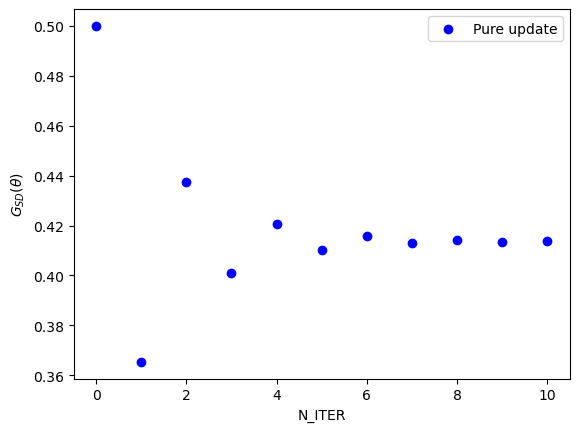

[0.5       +0.00000000e+00j 0.36534493+1.33153579e-18j
 0.43746768+1.18754019e-18j 0.4009405 -6.33580645e-19j
 0.42048585+2.67662411e-19j 0.41023802-2.76471554e-18j
 0.41568008-2.84941883e-18j 0.41280791+3.74388563e-19j
 0.41432895-2.31748214e-18j 0.41352486+3.20856080e-18j
 0.41395034+3.08319993e-18j]


In [7]:
i_range = np.arange(N_ITER)

G_tau_irange = np.zeros(i_range.shape, dtype=np.complex128)
for i in i_range:
    G_tau_irange[i] = G_tau(i, TAU_TEST)

print(G_tau_irange[-1])

if WEIGHTED_UPDATE:
    label = "Weighted update"
else:
    label = "Pure update"

plt.figure()
plt.scatter(i_range, G_tau_irange, c="b", label=label)
plt.xlabel("N_ITER")
plt.ylabel(r"$G_{SD}(\theta)$")
plt.legend()
plt.show()
plt.close()

print(G_tau_irange)

## Compute large-N, Schwinger-Dyson 2-point function

In [8]:
G_SD_range = Parallel(n_jobs=N_JOBS, verbose=1)(delayed(G_tau)(N_ITER, tau) for tau in tqdm(TAU_RANGE))

100%|██████████| 50/50 [00:00<00:00, 118.16it/s]
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=20)]: Done  50 out of  50 | elapsed:    5.6s finished


c:\Users\abdel\anaconda3\envs\phys417\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


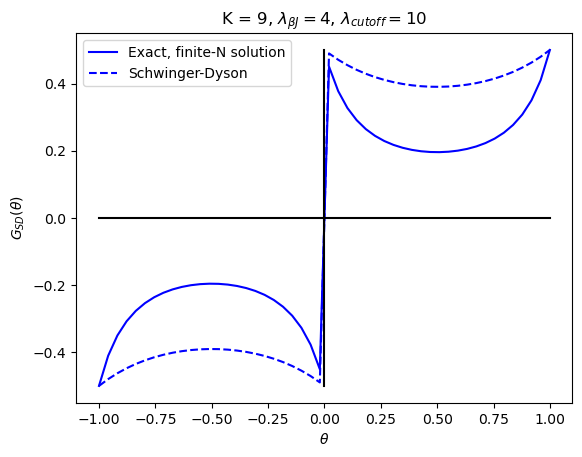

In [9]:
plt.figure()
plt.plot(TAU_RANGE, G_finite_range, label="Exact, finite-N solution", c="b")
plt.plot(TAU_RANGE, G_SD_range, label="Schwinger-Dyson", c="b", linestyle="dashed")

# Plot axes
y_range = np.linspace(np.max(G_SD_range), np.min(G_SD_range), 100)
plt.plot([0 for i in y_range], y_range, c="k")
x_range = np.linspace(np.min(TAU_RANGE), np.max(TAU_RANGE), 100)
plt.plot(x_range, [0 for i in x_range], c="k")

plt.xlabel(r"$\theta$")
plt.ylabel(r"$G_{SD}(\theta)$")
plt.title(f"K = {K}, "+r"$\lambda_{\beta J} = $"+f"{LAMBDA_BJ}, "+"$\lambda_{cutoff} = $"+f"{LAMBDA_cutoff}")
plt.legend()
plt.savefig(os.path.join("Images", "Schwinger_Dyson", f"K{K}_J{J:.2f}_Q{Q}_B{BETA}_Lcf{LAMBDA_cutoff}_W{int(WEIGHTED_UPDATE)}_2PNT.png"))
plt.show()
plt.close()

Not full agreement with Mathematica (see "schwinger_dyson.nb"). Our exact, finite results seem to match up. But our Schwinger-Dyson approximations do not. 

Could it be integration error??

Very strange mathematica behavior at:
- $\beta = 10$
- $K = 7$
- $J = 4$
- $Q = 4$
- $\lambda_1 = 1$
- $\lambda_2 = 10$
- $nIter = 11$
- $tauTest = 1/4$


And it gets EVEN STRANGER at $J=9$

Moreover, just because the SD converges (at the test-tau) does not mean that the SD and exact 2-pnt functions will match up exactly. (Maybe increase K in the exact fn?)

In [ ]:
i = 10
tau_test = 6
n_0 = - int(LAMBDA_cutoff)+3
tau_0 = -BETA/2

print(f"G_tau({i}, {tau_test}) = {G_tau(i, tau_test)}")
print(f"G({i}, {n_0}) = {G(i, n_0)}")
print(f"sigma({i}, {n_0}) = {sigma(i, n_0)}")
print(f"sigma_tau({i}, {tau_0}) = {sigma_tau(i, tau_0)}")